We’ll build a federated learning system using the **Flower framework**, **Flower Datasets** and **PyTorch**.
*   In part 1, we will use *Pytorch for model training pipeine and data loading*.
*   In part 2, we will form the Pytorch project using Flower.


**Step 0: Preparation**


---



Install dependencies


In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.

In [ ]:
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
# disable_progress_bar controls the visibility of progress bars
from torch.utils.data import DataLoader
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.16.0 / PyTorch 2.6.0+cu124


Load the data

1.   We're using Federated Learning by training CNN on CIFAR-10 dataset.
2.   Each organization will act as a client in the federated learning system.
3.   We're using the Flower Datasets library (*flwr-datasets*) to partition *CIFAR-10* using FederatedDataset. We'll create train and test set for each organization and give them to *PyTorch DataLoader*.




In [ ]:
NUM_CLIENTS=10
fds=FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})
fds

In [ ]:
fds.partitioners

{'train': <flwr_datasets.partitioner.iid_partitioner.IidPartitioner at 0x7bffe7d1e5d0>}

In [ ]:
NUM_CLIENTS = 10
BATCH_SIZE = 32
# partition_id refers to client (0-9)
def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS}) #fds will contain the federated version of the CIFAR-10
    partition = fds.load_partition(partition_id)
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize(mean,std_dev)
        ]
    )

    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]] #batch["img"] refers to list of images
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True # Retrieve training partition of the dataset from partition_train_test
    )
    valloader = DataLoader(
        partition_train_test["test"], batch_size=BATCH_SIZE
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(
        testset, batch_size=BATCH_SIZE
    )
    return trainloader, valloader, testloader

In [ ]:
total_train = fds.load_split("train")
print(len(total_train))
total_test = fds.load_split("test")
print(len(total_test))

50000
10000


In [ ]:
print(len(partition))
print(len(partition_train_test["train"]))
print(len(partition_train_test["test"]))

5000
4000
1000


In [ ]:
fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})
partition = fds.load_partition(1)
partition_train_test = partition.train_test_split(test_size=0.2, seed=42)

def apply_transforms(batch):
    batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
    return batch

trainloader = DataLoader(
    partition_train_test["train"],
    batch_size=BATCH_SIZE,
    shuffle=True
)
valloader = DataLoader(
    partition_train_test["test"], batch_size=BATCH_SIZE
)

testset = fds.load_split("test").with_transform(apply_transforms)
testloader = DataLoader(
    testset, batch_size=BATCH_SIZE
)
print(trainloader)  # Print DataLoader object reference
print(valloader)
print(testloader)

In [ ]:
fds.load_partition(1)

Dataset({
    features: ['img', 'label'],
    num_rows: 5000
})

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

pytorch_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL.Image to Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def apply_transforms(batch):
    batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
    return batch

partition_train_test = partition_train_test.with_transform(apply_transforms)

BATCH_SIZE = 32
trainloader = DataLoader(
    partition_train_test["train"],
    batch_size=BATCH_SIZE,
    shuffle=True
)
valloader = DataLoader(
    partition_train_test["test"],
    batch_size=BATCH_SIZE
)
testset = fds.load_split("test").with_transform(apply_transforms)
testloader = DataLoader(
    testset,
    batch_size=BATCH_SIZE
)

for batch in trainloader:
    print(batch)
    break

{'img': tensor([[[[-0.0824, -0.0667, -0.0745,  ..., -0.2784, -0.2941, -0.3255],
          [-0.0510, -0.0745, -0.0824,  ..., -0.3882, -0.4196, -0.4431],
          [-0.1843, -0.2078, -0.2000,  ..., -0.3412, -0.3804, -0.4039],
          ...,
          [ 0.2157,  0.2471,  0.2863,  ..., -0.0275, -0.0196, -0.0039],
          [ 0.2706,  0.2706,  0.2706,  ..., -0.0353,  0.0196,  0.0118],
          [ 0.2549,  0.1843,  0.0667,  ..., -0.0745, -0.0431, -0.0510]],

         [[-0.1059, -0.0902, -0.0902,  ..., -0.2863, -0.3020, -0.3333],
          [-0.1059, -0.1294, -0.1294,  ..., -0.3961, -0.4275, -0.4510],
          [-0.2392, -0.2627, -0.2627,  ..., -0.3490, -0.3804, -0.4118],
          ...,
          [ 0.1294,  0.1608,  0.2000,  ..., -0.0980, -0.0902, -0.0745],
          [ 0.1843,  0.1843,  0.1843,  ..., -0.1059, -0.0510, -0.0588],
          [ 0.1686,  0.0980, -0.0196,  ..., -0.1529, -0.1137, -0.1294]],

         [[-0.1373, -0.1294, -0.1294,  ..., -0.2392, -0.2549, -0.2941],
          [-0.1686, -0

In [ ]:
for batch in trainloader:
  print(batch['img'][0])
  print(batch['img'][0].shape)
  print(batch['label'][0])
  break

tensor([[[ 0.4510,  0.3882,  0.3647,  ..., -0.1843, -0.0275,  0.0980],
         [ 0.1529,  0.0980,  0.0588,  ..., -0.6235, -0.3098, -0.0353],
         [-0.1294, -0.1451, -0.2000,  ..., -0.6627, -0.4039, -0.0902],
         ...,
         [ 0.0588,  0.1529,  0.2784,  ...,  0.1216,  0.1529,  0.1059],
         [ 0.2235,  0.1216,  0.1529,  ...,  0.1059,  0.1294,  0.0588],
         [ 0.3020,  0.2078,  0.1843,  ...,  0.1373,  0.1294,  0.1216]],

        [[ 0.3569,  0.2941,  0.2706,  ..., -0.2941, -0.1294,  0.0118],
         [ 0.0902,  0.0431, -0.0039,  ..., -0.6863, -0.3647, -0.0902],
         [-0.1686, -0.1843, -0.2392,  ..., -0.6706, -0.4039, -0.1137],
         ...,
         [-0.1059,  0.0275,  0.1059,  ..., -0.0196,  0.0039, -0.0510],
         [ 0.0588, -0.0039, -0.0275,  ..., -0.0510, -0.0275, -0.1059],
         [ 0.1216,  0.0431, -0.0039,  ..., -0.0039, -0.0196, -0.0431]],

        [[ 0.1843,  0.1216,  0.0980,  ..., -0.3725, -0.2471, -0.0588],
         [-0.0588, -0.1059, -0.1451,  ..., -0

In [ ]:
print(len(trainloader.dataset))
print(len(trainloader)) # 32*len(trainloader)=4000

4000
125


In [ ]:
for batch in trainloader:
    print("Image batch shape:", batch['img'].shape)
    print("Label batch shape:", batch['label'].shape)
    break

Image batch shape: torch.Size([32, 3, 32, 32])
Label batch shape: torch.Size([32])


In [ ]:
for batch in trainloader:
    image = batch['img'][3]
    label = batch['label'][3]
    break

print(f"Shape of one image: {image.shape}")
print(label)
print(label.item())

Shape of one image: torch.Size([3, 32, 32])
tensor(9)
9


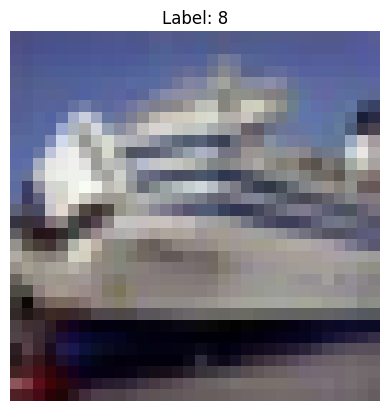

In [ ]:
import matplotlib.pyplot as plt
import torchvision

image = batch['img'][31]
label = batch['label'][31]

image = image*0.5+0.5

plt.imshow(image.permute(1,2,0).numpy())
plt.title(f"Label: {label.item()}")
plt.axis('off')
plt.show()

In [ ]:
for batch in valloader:
  print(batch)
  break

{'img': tensor([[[[-0.2627, -0.1686, -0.2235,  ..., -0.0745, -0.2157, -0.2941],
          [-0.1216, -0.1843, -0.2078,  ..., -0.0118, -0.1059, -0.2235],
          [ 0.0275, -0.2627, -0.2471,  ..., -0.1216, -0.1686, -0.1686],
          ...,
          [ 0.7569,  0.8196,  0.6784,  ...,  0.7569,  0.7569,  0.7647],
          [ 0.6392,  0.7882,  0.6941,  ...,  0.7020,  0.6863,  0.7490],
          [ 0.5843,  0.6471,  0.6627,  ...,  0.6157,  0.6392,  0.7490]],

         [[-0.2549, -0.1451, -0.2000,  ..., -0.0353, -0.1843, -0.2392],
          [-0.1216, -0.2157, -0.2235,  ..., -0.0118, -0.0824, -0.1922],
          [-0.0118, -0.3020, -0.2627,  ..., -0.1451, -0.1451, -0.1608],
          ...,
          [ 0.7098,  0.7882,  0.6078,  ...,  0.6314,  0.6471,  0.6471],
          [ 0.5765,  0.7412,  0.6078,  ...,  0.6157,  0.6157,  0.6706],
          [ 0.5529,  0.6000,  0.5608,  ...,  0.5765,  0.6157,  0.7176]],

         [[-0.5451, -0.4902, -0.5373,  ..., -0.4039, -0.5686, -0.6000],
          [-0.4275, -0

In [ ]:
def count_images(loader):
    total_images = 0
    for batch in loader:
        total_images += len(batch['img'])
    return total_images

train_images = count_images(trainloader)
val_images = count_images(valloader)
test_images = count_images(testloader)
print(f"Total images in trainloader: {train_images}")
print(f"Total images in valloader: {val_images}")
print(f"Total images in testloader: {test_images}")

Total images in trainloader: 4000
Total images in valloader: 1000
Total images in testloader: 10000


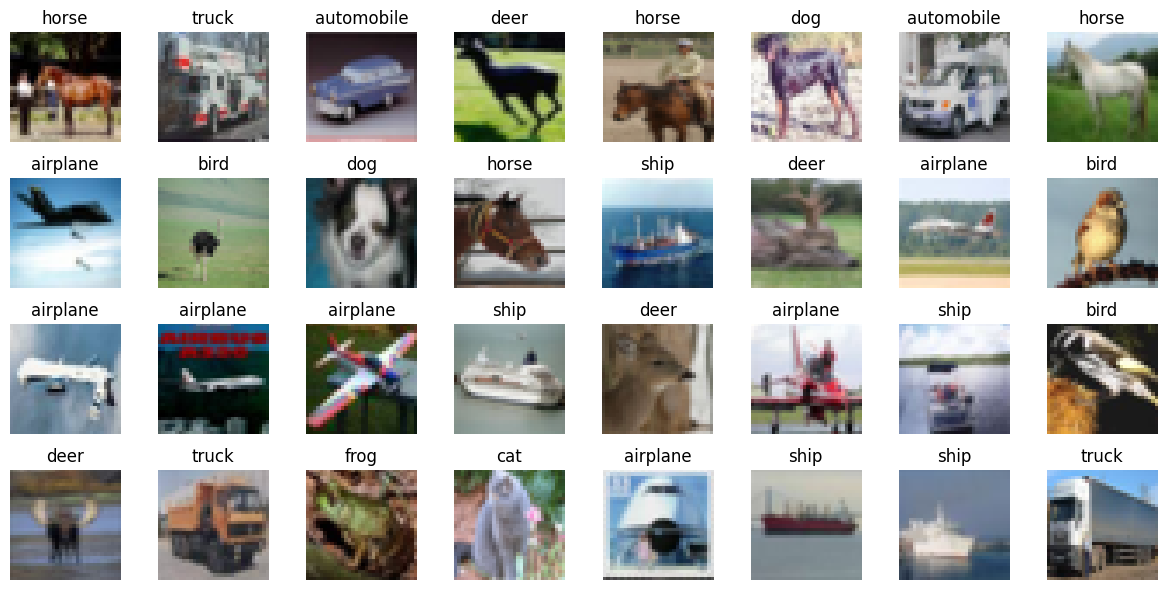

In [ ]:
trainloader, _, _ = load_datasets(partition_id=0)
batch = next(iter(trainloader))
# iter(trainloader): Converts the trainloader into an iterator which can be used to fetch batches of data one by one.
# next(): Fetches the next batch of data from the iterator.
# batch = next(iter(trainloader)) fetches one batch of data from the trainloader.
images, labels = batch["img"], batch["label"]

images = images.permute(0, 2, 3, 1).numpy() # [Batch, Channels, Height, Width] → [Batch, Height, Width, Channels]
images = images / 2 + 0.5 # denormalise

fig, axs = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

fig.tight_layout()
plt.show()

In [ ]:
from collections import Counter

NUM_CLIENTS = 10
NUM_CLASSES = 10

total_counts_client_class = np.zeros((NUM_CLASSES, NUM_CLIENTS)) # (10*10)
for client_id in range(NUM_CLIENTS):
    trainloader, _, _ = load_datasets(client_id)
    label_list = []
    for batch in trainloader:
        labels = batch["label"] # 32 sized tensor and converting it into list by labels.tolist() & appending it to label_list
        label_list.extend(labels.tolist())
    class_counts = Counter(label_list)
    # Counter(label_list) is a dictionary to store one client has how many objects of 10 classes
    for cls in range(NUM_CLASSES):
        total_counts_client_class[cls][client_id] = class_counts.get(cls, 0)

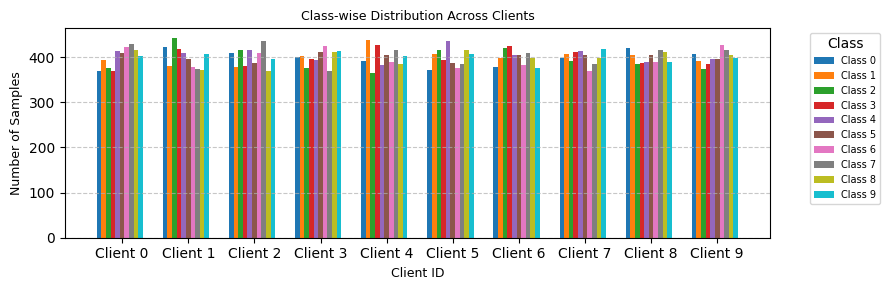

In [ ]:
x=np.arange(NUM_CLIENTS)
bar_width=0.07

plt.figure(figsize=(9,3))

for cls in range(NUM_CLASSES):
    plt.bar(x+cls*bar_width,total_counts_client_class[cls],width=bar_width,label=f'Class {cls}')

plt.xlabel("Client ID", fontsize=9)
plt.ylabel("Number of Samples", fontsize=9)
plt.title("Class-wise Distribution Across Clients", fontsize=9)
plt.xticks(x+bar_width*NUM_CLASSES/2, [f"Client {i}" for i in range(NUM_CLIENTS)])
plt.legend(title="Class",bbox_to_anchor=(1.05,1),loc="upper left",fontsize=7)
plt.grid(axis='y',linestyle='--',alpha=0.7)
plt.tight_layout()
plt.show()

**Step 1: Centralized training with Pytorch**

---



Define the model

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def train(net, trainloader):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    correct, total, train_loss = 0, 0, 0.0
    for batch in trainloader:
      images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
      optimizer.zero_grad() # Clear the gradients of all optimized tensors
      outputs = net(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step() # Update model parameters

      train_loss += loss.item()
      total += labels.size(0)
      correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
    train_loss /= len(trainloader.dataset)
    train_acc = correct / total
    return train_loss, train_acc

In [ ]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    # disable gradient computation during evaluation
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

Train the model

In [ ]:
trainloader, valloader, testloader = load_datasets(partition_id=0)
net = Net().to(DEVICE)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(20):
    train_loss, train_acc = train(net, trainloader)
    val_loss, val_acc = test(net, valloader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

Epoch 1: Train Loss 0.0652, Train Acc 0.2160 | Val Loss 0.0609, Val Acc 0.2880
Epoch 2: Train Loss 0.0582, Train Acc 0.3197 | Val Loss 0.0562, Val Acc 0.3420
Epoch 3: Train Loss 0.0552, Train Acc 0.3490 | Val Loss 0.0544, Val Acc 0.3630
Epoch 4: Train Loss 0.0528, Train Acc 0.3792 | Val Loss 0.0523, Val Acc 0.3920
Epoch 5: Train Loss 0.0512, Train Acc 0.3997 | Val Loss 0.0517, Val Acc 0.4030
Epoch 6: Train Loss 0.0499, Train Acc 0.4293 | Val Loss 0.0504, Val Acc 0.4170
Epoch 7: Train Loss 0.0484, Train Acc 0.4407 | Val Loss 0.0500, Val Acc 0.4280
Epoch 8: Train Loss 0.0469, Train Acc 0.4600 | Val Loss 0.0484, Val Acc 0.4530
Epoch 9: Train Loss 0.0459, Train Acc 0.4680 | Val Loss 0.0501, Val Acc 0.4310
Epoch 10: Train Loss 0.0440, Train Acc 0.4905 | Val Loss 0.0491, Val Acc 0.4410
Epoch 11: Train Loss 0.0426, Train Acc 0.5068 | Val Loss 0.0469, Val Acc 0.4760
Epoch 12: Train Loss 0.0416, Train Acc 0.5182 | Val Loss 0.0483, Val Acc 0.4430
Epoch 13: Train Loss 0.0401, Train Acc 0.5350 | V

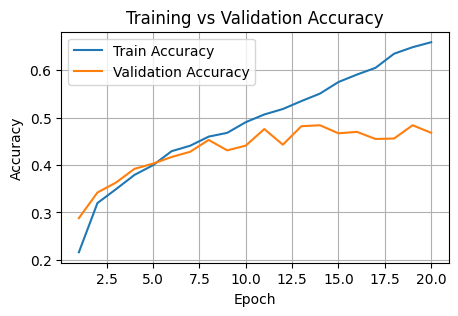

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(range(1, 21), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 21), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
loss, accuracy = test(net, testloader)
print(f"Final test set performance:\nloss {loss}\naccuracy {accuracy}")

Final test set performance:
loss 0.051640652471780776
accuracy 0.4594


**Step 2: Federated Learning with Flower**

---



Step 1 showed simple centralized training pipeline. All data was in one place. Next, we’ll simulate a situation where we have multiple datasets in multiple organizations and train a model over these organizations using federated learning.

Update model parameters

In federated learning, server sends global model parameters to client and client updates local model with parameters received from server. It then trains the model on the local data and sends the updated model parameters back to server.

We need two helper functions to update local model with parameters received from the server and to get updated model parameters from the local model: set_parameters and get_parameters.

In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

*The set_parameters function updates the neural network (net) with given list of parameters received from server.*

*The get_parameters function extracts the current parameters (weights and biases) from the neural network (net) and converts them into a list of numpy.ndarray.*

Define the Flower ClientApp

In Flower, we create *ServerApp* and *ClientApp* to run the server-side and client-side code.

The first step toward creating a ClientApp is to implement subclasses of *flwr.client.Client* or *flwr.client.NumPyClient*.

For *NumpyClient* we need;


1.   get_parameters: return the current local model parameters
2.   fit: receive model parameters from server, train the model on local data and return the updated model parameters to the server
3.   evaluate: receive model parameters from server, evaluate the model on local data and return the evaluation result to the server

In [ ]:
# same code as above one
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    # config hold configurations related to training like number of epochs, learning rate, etc that control how the model is trained
    # or evaluated means hyperparameters
    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}
    # get_parameters(self.net) returns updated model parameters (weights and biases)
    # len(self.trainloader) returns number of training examples to perform weighted aggregation
    # {} optional metrics dictionary for loss, accuracy etc.

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

Class *FlowerClient* defines how local training/evaluation will be performed and allows *Flower* to call local training/evaluation through *fit* and *evaluate.*

Each instance of FlowerClient represents a single client in federated learning system.

*Flower* calls *FlowerClient.fit* on the instance when the server selects a particular client for training and *FlowerClient.evaluate* for evaluation.

*When training on a single machine, server and clients share CPU, GPU and memory.*

*Flower provides special simulation capabilities that create FlowerClient instance only when it is needed for training/evaluation and for this we need to implement a function client_fn.*

*In Flower, clients are identified as partition_id. We also create an instance of ClientApp and pass it the client_fn. ClientApp is the entrypoint that a running Flower client uses to call the code.*

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    # node_config fetch data partition associated to that node
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    # FlowerClient is subclass of NumPyClient so we need to call .to_client() to convert it to subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

Define the Flower Server App

*On server side, to configure a strategy which encapsulates the federated learning approach, we use Federated Averaging (FedAvg).*

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
# strategy refers how the server manages the training process across multiple clients. It includes aggregation method, selection of clients,
# model evaluation etc.
strategy = FedAvg(
    fraction_fit=1.0,  # 100% of available clients for training
    fraction_evaluate=0.5,  # 50% of available clients for evaluation
    min_fit_clients=10,  # Never less than 10 clients for training
    min_evaluate_clients=5,  # Never less than 5 clients for evaluation
    min_available_clients=10,  # Wait until 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,
)

*Also, we create ServerApp using a utility function server_fn. In server_fn, we pass an instance of ServerConfig for defining the number of federated learning rounds (num_rounds) and strategy. The server_fn returns ServerAppComponents object which contains the settings of ServerApp behaviour. ServerApp is the entrypoint that Flower uses to call server-side code.*

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    # Construct components that set the ServerApp behaviour.
    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

Run the training

In [ ]:
# backend_config is a configuration object that contains parameters related to the backend of a federated
# learning setup (like the server).
# Flower Server: When starting the federated learning process, the server will use the backend_config to
# control how the rounds of training are managed, how clients are chosen, how long the server waits for
# client responses, etc.

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

# 45.94% to 45.96% accuracy

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=3976) 2025-03-23 07:09:00.383627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=3976) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=3976) E0000 00:00:1742713740.442220    3976 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=3976) E0000 00:00:1742713740.462102    3976 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=3977) /usr/local/lib/python3.11/dist-packages/jupyter_client/con

Server side parameter initialization

*Flower initializes global model by asking one random client for the initial parameters by default. Flower allows to directly pass the initial parameters to the Strategy.*

In [ ]:
params = get_parameters(Net())

In [ ]:
from flwr.common import ndarrays_to_parameters

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedAvg(
        fraction_fit=0.3,
        fraction_evaluate=0.3,
        min_fit_clients=3,
        min_evaluate_clients=3,
        min_available_clients=NUM_CLIENTS,
        # Passing initial_parameters to FedAvg strategy prevents Flower from asking one of the clients.
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=weighted_average,
    )

    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=strategy, config=config)

In [ ]:
server = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": None}
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_gpus": 1}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
(pid=9504) 2025-03-23 07:25:51.369399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=9504) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=9504) E0000 00:00:1742714751.396246    9504 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=9504) E0000 00:00:1742714751.404141    9504 cuda_blas.cc:1418] Unable to register cuBLAS factory: Att

Starting with a customized strategy

*The function run_simulation accepts number of arguments, such as*
1. *server_app which wraps around the strategy and number of training rounds*
2. *client_app which wraps around the client_fn used to create FlowerClient instances and number of clients to simulate which equals num_supernodes.*

In [ ]:
from flwr.server.strategy import FedAdagrad
# FedAdagrad strategy instead of FedAvg strategy

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedAdagrad(
        fraction_fit=0.3,
        fraction_evaluate=0.3,
        min_fit_clients=3,
        min_evaluate_clients=3,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn=weighted_average,
    )

    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
(pid=11773) 2025-03-23 07:33:10.377501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=11773) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=11773) E0000 00:00:1742715190.405926   11773 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=11773) E0000 00:00:1742715190.413654   11773 cuda_blas.cc:1418] Unable to register cuBLAS factory:

**Centralized Evaluation (or server-side evaluation)**: *It works the same way that evaluation in centralized machine learning does.*

**Federated Evaluation (or client-side evaluation)**: *It doesn’t require a centralized dataset and allows to evaluate models over a larger datasets The dataset held by each client can change over consecutive rounds. This can lead to evaluation results that are not stables.*

In [ ]:
from typing import Dict, Optional, Tuple
from flwr.common import NDArrays, Scalar

In [ ]:
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar], # config is Flower standard function signature to dynamically pass extra info to the evaluation function
) -> Optional[Tuple[float, Dict[str, Scalar]]]: # float -> loss; str -> (accuracy/precision/recall); Scalar -> value of accuracy/precision/recall

    net = Net().to(DEVICE)
    _, _, testloader = load_datasets(0)
    set_parameters(net, parameters)
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedAvg(
        fraction_fit=0.3,
        fraction_evaluate=0.3,
        min_fit_clients=3,
        min_evaluate_clients=3,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=evaluate,
    )

    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
if DEVICE=="cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1}}
else:
    backend_config = {"client_resources": {"num_cpus": 1}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
(pid=5710) 2025-03-23 08:12:10.673562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=5710) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=5710) E0000 00:00:1742717530.713749    5710 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=5710) E0000 00:00:1742717530.723627    5710 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO :      initial parameters (loss, other metrics): 0.07216335697174

Server-side evaluation loss 0.07216335697174073 / accuracy 0.1


(ClientAppActor pid=5710) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=5710) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=5710) see the appropriate new directories, set the environment variable
(ClientAppActor pid=5710) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=5710) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=5710)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (1, 0.06004544078111648, {'accuracy': 0.3375}, 45.31519573799983)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.06004544078111648 / accuracy 0.3375


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (2, 0.05325291726589203, {'accuracy': 0.3896}, 112.8941868989998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.05325291726589203 / accuracy 0.3896


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (3, 0.05033583475351334, {'accuracy': 0.4171}, 162.9855975559999)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.05033583475351334 / accuracy 0.4171


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (4, 0.04869494352340698, {'accuracy': 0.4356}, 218.7485513649999)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04869494352340698 / accuracy 0.4356


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (5, 0.04716032942533493, {'accuracy': 0.4504}, 260.9795387529998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04716032942533493 / accuracy 0.4504


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 283.42s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06187568533420562
INFO :      		round 2: 0.05483217672506968
INFO :      		round 3: 0.05208906304836273
INFO :      		round 4: 0.049401883204778035
INFO :      		round 5: 0.04813798371950786
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07216335697174073
INFO :      		round 1: 0.06004544078111648
INFO :      		round 2: 0.05325291726589203
INFO :      		round 3: 0.05033583475351334
INFO :      		round 4: 0.04869494352340698
INFO :      		round 5: 0.04716032942533493
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.1),
INFO :      	              (1, 0.3375),
INFO :      	              (2, 0.3896),
INFO :      	              (3, 0.4171),
INFO :      	              (4, 0.4356),
INFO :      	              (5, 0.4504)]}
INFO :     

Sending/receiving arbitrary values to/from clients

Now, we’ll tell at runtime from the server how many epochs (or other parameters) to use."

We're enabling dynamic control from the server side to make it flexible.

Ex. -> In Round 1, train for 1 epoch; In Round 2, train for 2 epochs; Later rounds, increase epochs dynamically or change learning rate mid-training.

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, pid, net, trainloader, valloader):
        self.pid = pid  # Partition ID of a client
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config): # config is a dictionary to store hyperparamaters
        print(f"[Client {self.pid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        server_round = config["server_round"] # current round of training in the federated learning process
        local_epochs = config["local_epochs"] # number of local epochs each client should train its data before sending updates back to server
        print(f"[Client {self.pid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.pid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id)
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [ ]:
def fit_config(server_round: int):
    # Return training configuration dict for each round.
    config = {
        "server_round": server_round,
        "local_epochs": 1 if server_round < 2 else 2,
    }
    return config

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedAvg(
        fraction_fit=0.3,
        fraction_evaluate=0.3,
        min_fit_clients=3,
        min_evaluate_clients=3,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=evaluate,
        on_fit_config_fn=fit_config,
    )

    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
(pid=14084) 2025-03-23 08:43:42.255450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=14084) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=14084) E0000 00:00:1742719422.281433   14084 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=14084) E0000 00:00:1742719422.288950   14084 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO :      initial parameters (loss, other metrics): 0.0721633569

Server-side evaluation loss 0.07216335697174073 / accuracy 0.1


(ClientAppActor pid=14084) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=14084) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=14084) see the appropriate new directories, set the environment variable
(ClientAppActor pid=14084) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=14084) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=14084)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


(ClientAppActor pid=14084) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=14084) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=14084) [Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (1, 0.05983357099294662, {'accuracy': 0.3247}, 36.672041444000115)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.05983357099294662 / accuracy 0.3247
(ClientAppActor pid=14084) [Client 2] evaluate, config: {}
(ClientAppActor pid=14084) [Client 3] evaluate, config: {}
(ClientAppActor pid=14084) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)


(ClientAppActor pid=14084) [Client 2, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(ClientAppActor pid=14084) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}
(ClientAppActor pid=14084) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 2}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (2, 0.05080272290706635, {'accuracy': 0.4074}, 98.91980180100018)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.05080272290706635 / accuracy 0.4074
(ClientAppActor pid=14084) [Client 0] evaluate, config: {}
(ClientAppActor pid=14084) [Client 1] evaluate, config: {}
(ClientAppActor pid=14084) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)


(ClientAppActor pid=14084) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(ClientAppActor pid=14084) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}
(ClientAppActor pid=14084) [Client 8, round 3] fit, config: {'server_round': 3, 'local_epochs': 2}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (3, 0.04780439101457596, {'accuracy': 0.443}, 178.4073666170002)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04780439101457596 / accuracy 0.443
(ClientAppActor pid=14084) [Client 1] evaluate, config: {}
(ClientAppActor pid=14084) [Client 6] evaluate, config: {}
(ClientAppActor pid=14084) [Client 9] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)


(ClientAppActor pid=14084) [Client 2, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(ClientAppActor pid=14084) [Client 8, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}
(ClientAppActor pid=14084) [Client 9, round 4] fit, config: {'server_round': 4, 'local_epochs': 2}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (4, 0.0466624495267868, {'accuracy': 0.4565}, 238.5788861130004)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.0466624495267868 / accuracy 0.4565
(ClientAppActor pid=14084) [Client 2] evaluate, config: {}
(ClientAppActor pid=14084) [Client 5] evaluate, config: {}
(ClientAppActor pid=14084) [Client 9] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)


(ClientAppActor pid=14084) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(ClientAppActor pid=14084) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}
(ClientAppActor pid=14084) [Client 5, round 5] fit, config: {'server_round': 5, 'local_epochs': 2}


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      fit progress: (5, 0.04391511167883873, {'accuracy': 0.4897}, 298.4324322450002)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)


Server-side evaluation loss 0.04391511167883873 / accuracy 0.4897
(ClientAppActor pid=14084) [Client 0] evaluate, config: {}
(ClientAppActor pid=14084) [Client 1] evaluate, config: {}
(ClientAppActor pid=14084) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 314.76s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06103747196992238
INFO :      		round 2: 0.05169723093509674
INFO :      		round 3: 0.05007070600986482
INFO :      		round 4: 0.04787637074788411
INFO :      		round 5: 0.045039612452189126
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07216335697174073
INFO :      		round 1: 0.05983357099294662
INFO :      		round 2: 0.05080272290706635
INFO :      		round 3: 0.04780439101457596
INFO :      		round 4: 0.0466624495267868
INFO :      		round 5: 0.04391511167883873
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.1),
INFO :      	              (1, 0.3247),
INFO :      	              (2, 0.4074),
INFO :      	              (3, 0.443),
INFO :      	              (4, 0.4565),
INFO :      	              (5, 0.4897)]}
INFO :      


***For large number of clients***

In [ ]:
NUM_CLIENTS = 1000

In [ ]:
def fit_config(server_round: int):
    config = {
        "server_round": server_round,
        "local_epochs": 3,
    }
    return config


def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedAvg(
        fraction_fit=0.025,
        fraction_evaluate=0.05,
        min_fit_clients=20,
        min_evaluate_clients=40,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=evaluate,
        on_fit_config_fn=fit_config,
    )

    config = ServerConfig(num_rounds=2)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=2, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

(pid=2171) 2025-03-23 09:30:58.935679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=2171) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=2171) E0000 00:00:1742722259.068351    2171 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=2171) E0000 00:00:1742722259.095788    2171 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO :      initial parameters (loss, other metrics): 0.07211904981136322, {'accuracy': 0.0994}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 25 clients (out of 1000)


Server-side evaluation loss 0.07211904981136322 / accuracy 0.0994


(ClientAppActor pid=2172) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=2172) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=2172) see the appropriate new directories, set the environment variable
(ClientAppActor pid=2172) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=2172) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=2172)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
(pid=2172) 2025-03-23 09:30:59.043031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=2172) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=2172) E0000 00:00:1742722259.1368

(ClientAppActor pid=2172) [Client 912, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(ClientAppActor pid=2172) [Client 279, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(ClientAppActor pid=2172) [Client 455, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(ClientAppActor pid=2172) [Client 822, round 1] fit, config: {'server_round': 1, 'local_epochs': 3} [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=2172) [Client 791, round 1] fit, config: {'server_round': 1, 'local_epochs': 3} [repeated 6x across cluster]
(ClientAppActor pid=2171) [Client 51, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(ClientAppActor pid=2172) [Client 988, round 1] fit, config: {'server_round': 1, 'local_epochs': 3}
(ClientAppActor pid=2172) [Cli

INFO :      aggregate_fit: received 25 results and 0 failures


(ClientAppActor pid=2172) [Client 355, round 1] fit, config: {'server_round': 1, 'local_epochs': 3} [repeated 5x across cluster]


INFO :      fit progress: (1, 0.07188865196704865, {'accuracy': 0.115}, 68.38459819500002)
INFO :      configure_evaluate: strategy sampled 50 clients (out of 1000)


Server-side evaluation loss 0.07188865196704865 / accuracy 0.115
(ClientAppActor pid=2172) [Client 31] evaluate, config: {}
(ClientAppActor pid=2171) [Client 157] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=2171) [Client 789] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=2172) [Client 144] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2172) [Client 267] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=2172) [Client 605] evaluate, config: {}
(ClientAppActor pid=2171) [Client 121] evaluate, config: {}
(ClientAppActor pid=2171) [Client 92] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=2172) [Client 635] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2171) [Client 265] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2172) [Client 280] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=2172) [Client 401] evalua

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 25 clients (out of 1000)


(ClientAppActor pid=2172) [Client 202, round 2] fit, config: {'server_round': 2, 'local_epochs': 3}
(ClientAppActor pid=2171) [Client 933] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=2171) [Client 433, round 2] fit, config: {'server_round': 2, 'local_epochs': 3} [repeated 3x across cluster]
(ClientAppActor pid=2171) [Client 625, round 2] fit, config: {'server_round': 2, 'local_epochs': 3} [repeated 4x across cluster]
(ClientAppActor pid=2172) [Client 620, round 2] fit, config: {'server_round': 2, 'local_epochs': 3} [repeated 2x across cluster]
(ClientAppActor pid=2172) [Client 701, round 2] fit, config: {'server_round': 2, 'local_epochs': 3} [repeated 3x across cluster]
(ClientAppActor pid=2171) [Client 246, round 2] fit, config: {'server_round': 2, 'local_epochs': 3} [repeated 6x across cluster]


INFO :      aggregate_fit: received 25 results and 0 failures


(ClientAppActor pid=2172) [Client 135, round 2] fit, config: {'server_round': 2, 'local_epochs': 3} [repeated 6x across cluster]


INFO :      fit progress: (2, 0.07140122981071473, {'accuracy': 0.1308}, 218.59098589800004)
INFO :      configure_evaluate: strategy sampled 50 clients (out of 1000)


Server-side evaluation loss 0.07140122981071473 / accuracy 0.1308
(ClientAppActor pid=2172) [Client 129] evaluate, config: {}
(ClientAppActor pid=2172) [Client 169] evaluate, config: {}
(ClientAppActor pid=2171) [Client 928] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=2172) [Client 63] evaluate, config: {} [repeated 6x across cluster]
(ClientAppActor pid=2172) [Client 485] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=2171) [Client 461] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2172) [Client 418] evaluate, config: {}
(ClientAppActor pid=2171) [Client 822] evaluate, config: {}
(ClientAppActor pid=2172) [Client 450] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2172) [Client 379] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=2172) [Client 52] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=2172) [Client 15] evaluate, config: {} [repeated 4x a

INFO :      aggregate_evaluate: received 50 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 2 round(s) in 298.68s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.229533004283905
INFO :      		round 2: 0.22824157333374032
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07211904981136322
INFO :      		round 1: 0.07188865196704865
INFO :      		round 2: 0.07140122981071473
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.0994), (1, 0.115), (2, 0.1308)]}
INFO :      


(ClientAppActor pid=2171) [Client 265] evaluate, config: {} [repeated 2x across cluster]


(ClientAppActor pid=2171) /usr/local/lib/python3.11/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=2171) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=2171) see the appropriate new directories, set the environment variable
(ClientAppActor pid=2171) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=2171) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=2171)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


***Build a strategy from scratch***

In [ ]:
from typing import Union
# EvaluateIns -> Instructions from the server to client for evaluation
# EvaluateRes -> Results from client after evaluation
# FitIns -> Instructions for training
# FitRes -> Results from client training
from flwr.common import EvaluateIns, EvaluateRes, FitIns, FitRes, Parameters, Scalar, parameters_to_ndarrays, ndarrays_to_parameters
from flwr.server.client_manager import ClientManager
# Manages all connected clients on the server side.
from flwr.server.client_proxy import ClientProxy
# Proxy representation of client on the server side to send instructions to individual clients and receive their responses
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

This class is a custom implementation of a federated learning strategy (Similar to FedAvg) but with added customization like sending different learning rates to different clients during training by (configure_fit).

In [ ]:
class FedCustom():
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:

        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients

    #  String representation which is helpful in logs or printing the strategy name
    def __repr__(self) -> str:
        return "FedCustom"

    # How many clients to sample in each round for fit/evaluate
    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

    # Called at the start of training to initialize the global model
    # Define model (net = Net()), get its weights (get_parameters) and convert them to Parameters from numpy arrays
    def initialize_parameters(
        self,
        client_manager: ClientManager
    ) -> Optional[Parameters]:
        # Initialize global model parameters
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    # select clients for training and give training instructions
    def configure_fit(
        self,
        server_round: int,
        parameters: Parameters,
        client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:

        """Configure the next round of training."""
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)

        n_clients = len(clients)
        half_clients = n_clients // 2
        standard_config = {"lr": 0.001}
        higher_lr_config = {"lr": 0.003}
        fit_configurations = [] # fit_configurations is a list of tuples
        for idx, client in enumerate(clients): #idx represent id
            if idx < half_clients:
                fit_configurations.append((client, FitIns(parameters, standard_config)))
            else:
                fit_configurations.append((client, FitIns(parameters, higher_lr_config)))

        return fit_configurations
        # [
        #   (Client1, FitIns(global_model_parameters, {"lr": 0.001})),
        #   (Client2, FitIns(global_model_parameters, {"lr": 0.001})),
        #   (Client3, FitIns(global_model_parameters, {"lr": 0.003})),
        #   (Client4, FitIns(global_model_parameters, {"lr": 0.003})),
        # ]

    def fit(self, parameters: Parameters, config: Dict[str, Scalar]) -> Tuple[Parameters, int, Dict[str, Scalar]]:
      print(f"Client {self.cid} | Learning Rate: {config['lr']}, Round: {config['server_round']}")

    # select clients for evaluation
    # After clients train locally, the server gets their results and use this to aggregate models from all clients.
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:

        """Aggregate fit results using weighted average."""
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    # Called when the server wants to evaluate the current global model on clients
    def configure_evaluate(
        self,
        server_round: int,
        parameters: Parameters,
        client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:

        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        sample_size, min_num_clients = self.num_evaluation_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)

        return [(client, evaluate_ins) for client in clients]

    # After evaluation is done on clients, aggregate their losses.
    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:

        """Aggregate evaluation losses using weighted average."""
        if not results:
            return None, {}
        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}

        total_examples = sum(evaluate_res.num_examples for _, evaluate_res in results)
        total_accuracy = 0.0
        for _, evaluate_res in results:
            num_examples = evaluate_res.num_examples
            accuracy = evaluate_res.metrics.get("accuracy", None)
            if accuracy is not None:
                total_accuracy += num_examples * accuracy

        avg_accuracy = total_accuracy / total_examples if total_examples > 0 else None

        # Print both loss and accuracy
        print(f"[Round {server_round}] Evaluation loss: {loss_aggregated:.4f}")
        if avg_accuracy is not None:
            print(f"[Round {server_round}] Evaluation accuracy: {avg_accuracy:.4f}")

        # Return metrics
        metrics_aggregated = {"accuracy": avg_accuracy} if avg_accuracy is not None else {}

        return loss_aggregated, metrics_aggregated

    # Server-side evaluation
    def evaluate(
        self,
        server_round: int,
        parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        return None # Not doing server-side evaluation

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=1)
    return ServerAppComponents(config=config,strategy=FedCustom())

server=ServerApp(server_fn=server_fn)